# HW-5 CART
Wyatt Blair

SID: 10420296

3/10/24


In [1]:
import pandas as pd
import numpy as np
import warnings
from tqdm.auto import tqdm

tqdm.pandas()
warnings.filterwarnings('ignore', category=RuntimeWarning)

/Users/wyatthenryblair/anaconda3/envs/torch20/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 5.1 -- Salary

In [2]:
occupation = ['Service'] * 3 + ['Management'] * 4 + ['Sales'] * 2 + ['Staff'] * 2
gender = ['F', 'M', 'M',   'M', 'F', 'M', 'F',  'F', 'M',  'F', 'M']
age = [45, 25, 33, 25, 35, 26, 45, 40, 30, 50, 25]
salary = np.array([48, 25, 35, 45, 65, 45, 70, 50, 40, 40, 25]) * 1e3

In [3]:
values = list(zip(
    occupation,   gender,    age,   salary
))
columns = [
    'occupation', 'gender', 'age', 'salary'
]
df = pd.DataFrame(data=values, columns=columns); df

,occupation,gender,age,salary
0,Service,F,45,48000.0
1,Service,M,25,25000.0
2,Service,M,33,35000.0
3,Management,M,25,45000.0
4,Management,F,35,65000.0
5,Management,M,26,45000.0
6,Management,F,45,70000.0
7,Sales,F,40,50000.0
8,Sales,M,30,40000.0
9,Staff,F,50,40000.0


In [4]:
features = columns.copy(); features.remove('salary')

In [5]:
def age_splits(age):

    if age <= 30:
        return "0-30"
    elif age <= 40:
        return "31-40"
    else:
        return "Above 40"

def salary_splits(salary):

    salary /= 1e3

    if salary <= 35:
        return '1'
    elif 35 < salary <= 45:
        return '2'
    elif 45 < salary <= 55:
        return '3'
    else:
        return '4'

In [6]:
df['age_splits'] = df['age'].apply(age_splits)
df['salary_splits'] = df['salary'].apply(salary_splits)


In [7]:
df

,occupation,gender,age,salary,age_splits,salary_splits
0,Service,F,45,48000.0,Above 40,3
1,Service,M,25,25000.0,0-30,1
2,Service,M,33,35000.0,31-40,1
3,Management,M,25,45000.0,0-30,2
4,Management,F,35,65000.0,31-40,4
5,Management,M,26,45000.0,0-30,2
6,Management,F,45,70000.0,Above 40,4
7,Sales,F,40,50000.0,31-40,3
8,Sales,M,30,40000.0,0-30,2
9,Staff,F,50,40000.0,Above 40,2


In [8]:
df_splits = pd.DataFrame(data=df[['occupation', 'gender', 'age_splits', 'salary_splits']].values, columns=['occupation', 'gender', 'age', 'salary'])

In [9]:
df_splits

,occupation,gender,age,salary
0,Service,F,Above 40,3
1,Service,M,0-30,1
2,Service,M,31-40,1
3,Management,M,0-30,2
4,Management,F,31-40,4
5,Management,M,0-30,2
6,Management,F,Above 40,4
7,Sales,F,31-40,3
8,Sales,M,0-30,2
9,Staff,F,Above 40,2


In [10]:
class SingleCART:

    def __init__(self, data, target):

        if isinstance(data, dict):
            data = pd.DataFrame(data)

        self.data = data
        self.target = target

        self.features = data.columns.to_list(); self.features.remove(target)

        self.unique_feat_vals = {feat: list(self.data[feat].unique()) for feat in self.features}
        self.unique_target_vals = list(self.data[self.target].unique())

        self.H_system = self.system_entropy()
        self.H_splits = self.split_entropies()
        self.information_gains = self.calculate_information_gains()

        if len(self.information_gains) == 0:
            self.best_split = None
            self.data_splits = {}
        else:
            self.best_split = self.get_best_split()
            self.data_splits = self.split_data()

    def calc_probabilities(self, feature):

        unique_feat_vals = self.unique_feat_vals[feature]
        unique_target_vals = self.unique_target_vals

        counts = self.data[[feature, self.target]].groupby(self.target).value_counts()
        count_mat = pd.DataFrame(
            data=np.zeros((len(unique_feat_vals), len(unique_target_vals))),
            columns=unique_target_vals,
            index=unique_feat_vals
        )

        for (t, f), val in zip(counts.index, counts.values):
            count_mat[t][f] = val

        probability_mat = (count_mat.T / count_mat.sum(axis=1)).T
        probability_mat.sort_index(axis=1, inplace=True)
        probability_mat.sort_index(axis=0, inplace=True)

        return probability_mat

    def calc_gini(self):

        gini_frames = {}
        for feature in self.features:

            probabilities = self.calc_probabilities(feature)
            terms = probabilities ** 2
            gini = 1 - terms.sum(axis=1)

            gini_frames.update({feature: gini})
        
        
        # THIS PART OF THE CODE WAS GENERATED USING ChatGPT 4.0 with the following prompt:
        '''
        i have a dictionary in python where the keys are column headers and the values are dataframes. 
        the indices of the dataframes may not be the same. i want to create one large dataframe where 
        the index is a superset of all dataframe indices, the column headers are the keys from the 
        original dictionary, and the values are the values of the dataframe stored under the associated key.
        how would you implement this?
        '''

        # Step 1: Create a superset of all indices
        all_indices = set()
        for df in gini_frames.values():
            all_indices = all_indices.union(set(df.index))

        # Step 2: Initialize an empty DataFrame with the superset of indices
        gini_frame = pd.DataFrame(index=list(all_indices))

        # Step 3: Iterate through the dictionary and populate the new DataFrame
        for key, df in gini_frames.items():
            for idx in all_indices:
                if idx in df.index:
                    # Assuming each DataFrame has only one column, adjust if it has multiple
                    gini_frame.loc[idx, key] = df.loc[idx]
                else:
                    # Optional: Specify a placeholder for missing values
                    gini_frame.loc[idx, key] = None  # Or pd.NA, np.nan, etc.

        # Optional Step: Sort the index if needed
        gini_frame.sort_index(inplace=True)
        # ==========================================================================

        return gini_frame

    def get_best_gini_split(self):

        gini_frame = self.calc_gini()
        stacked_gini = gini_frame.stack()
        min_index = stacked_gini.idxmin()
        min_row_index, min_column_name = min_index

        return min_row_index, min_column_name

    def system_entropy(self):

        probabilities = self.data[self.target].value_counts() / self.data.shape[0]
        logs = np.log2(probabilities)
        terms = -logs * probabilities
        entropy_value = terms.sum()

        return entropy_value

    def split_entropy(self, feature):

        probabilities = self.calc_probabilities(feature)

        logs = np.log2(probabilities)
        logs.replace([np.inf, -np.inf], 0, inplace=True)

        feature_terms = -probabilities * logs
        feature_entropies = feature_terms.sum(axis=1)

        n = self.data.shape[0]
        likelihoods = self.data[feature].value_counts() / n

        terms = feature_entropies * likelihoods
        entropy_value = terms.sum()

        return entropy_value

    def split_entropies(self):

        return {
            feat: self.split_entropy(feat)
            for feat in self.features
        }
    
    def calculate_information_gains(self):

        return {
            feat: self.H_system - H_split 
            for feat, H_split in self.H_splits.items()
        }

    def get_best_split(self):

        return max(
            self.information_gains.items(), key=lambda x: x[1]
        )
    
    def split_data(self):
        
        best_split_feat, best_split_information_gain = self.best_split
        unique_vals = self.unique_feat_vals[best_split_feat]

        split_data = {
            val: self.data[self.data[best_split_feat] == val].drop(columns=best_split_feat).to_dict()
            for val in unique_vals
        }

        return split_data


In [11]:
single_clf = SingleCART(df_splits, target='salary')

In [12]:
single_clf.information_gains

{'occupation': 0.9585429818803031,
 'gender': 0.6990199844009084,
 'age': 0.630393847840593}

### This would be the information gain from the best split 

In [13]:
single_clf.best_split

('occupation', 0.9585429818803031)

In [14]:
for split_feat_val, split_data in single_clf.data_splits.items():
    print(split_feat_val)
    print(pd.DataFrame(split_data))
    print('-'*50)

Service
  gender       age salary
0      F  Above 40      3
1      M      0-30      1
2      M     31-40      1
--------------------------------------------------
Management
  gender       age salary
3      M      0-30      2
4      F     31-40      4
5      M      0-30      2
6      F  Above 40      4
--------------------------------------------------
Sales
  gender    age salary
7      F  31-40      3
8      M   0-30      2
--------------------------------------------------
Staff
   gender       age salary
9       F  Above 40      2
10      M      0-30      1
--------------------------------------------------


___
## 5.2 -- Breast Cancer Diagnosis

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

### Apply same pre-processing as in HW-2-EDA, but use the median to keep categorical nature

In [16]:
data = pd.read_csv('../data/breast-cancer-wisconsin.csv')
data.drop(columns='Sample', inplace=True)

data.replace("?", np.NaN, inplace=True)
data['F6'] = data['F6'].astype(float)

for column in data:

    series = data[column]
    mean, median =  series.mean(), series.median()
    data[column].fillna(median, inplace=True)

target = 'Class'
features = data.columns.to_list(); features.remove(target)

In [17]:
train = data.sample(frac=0.7)
test = data.drop(index=train.index)

### Try sklearn first to get an idea of what my model should look like

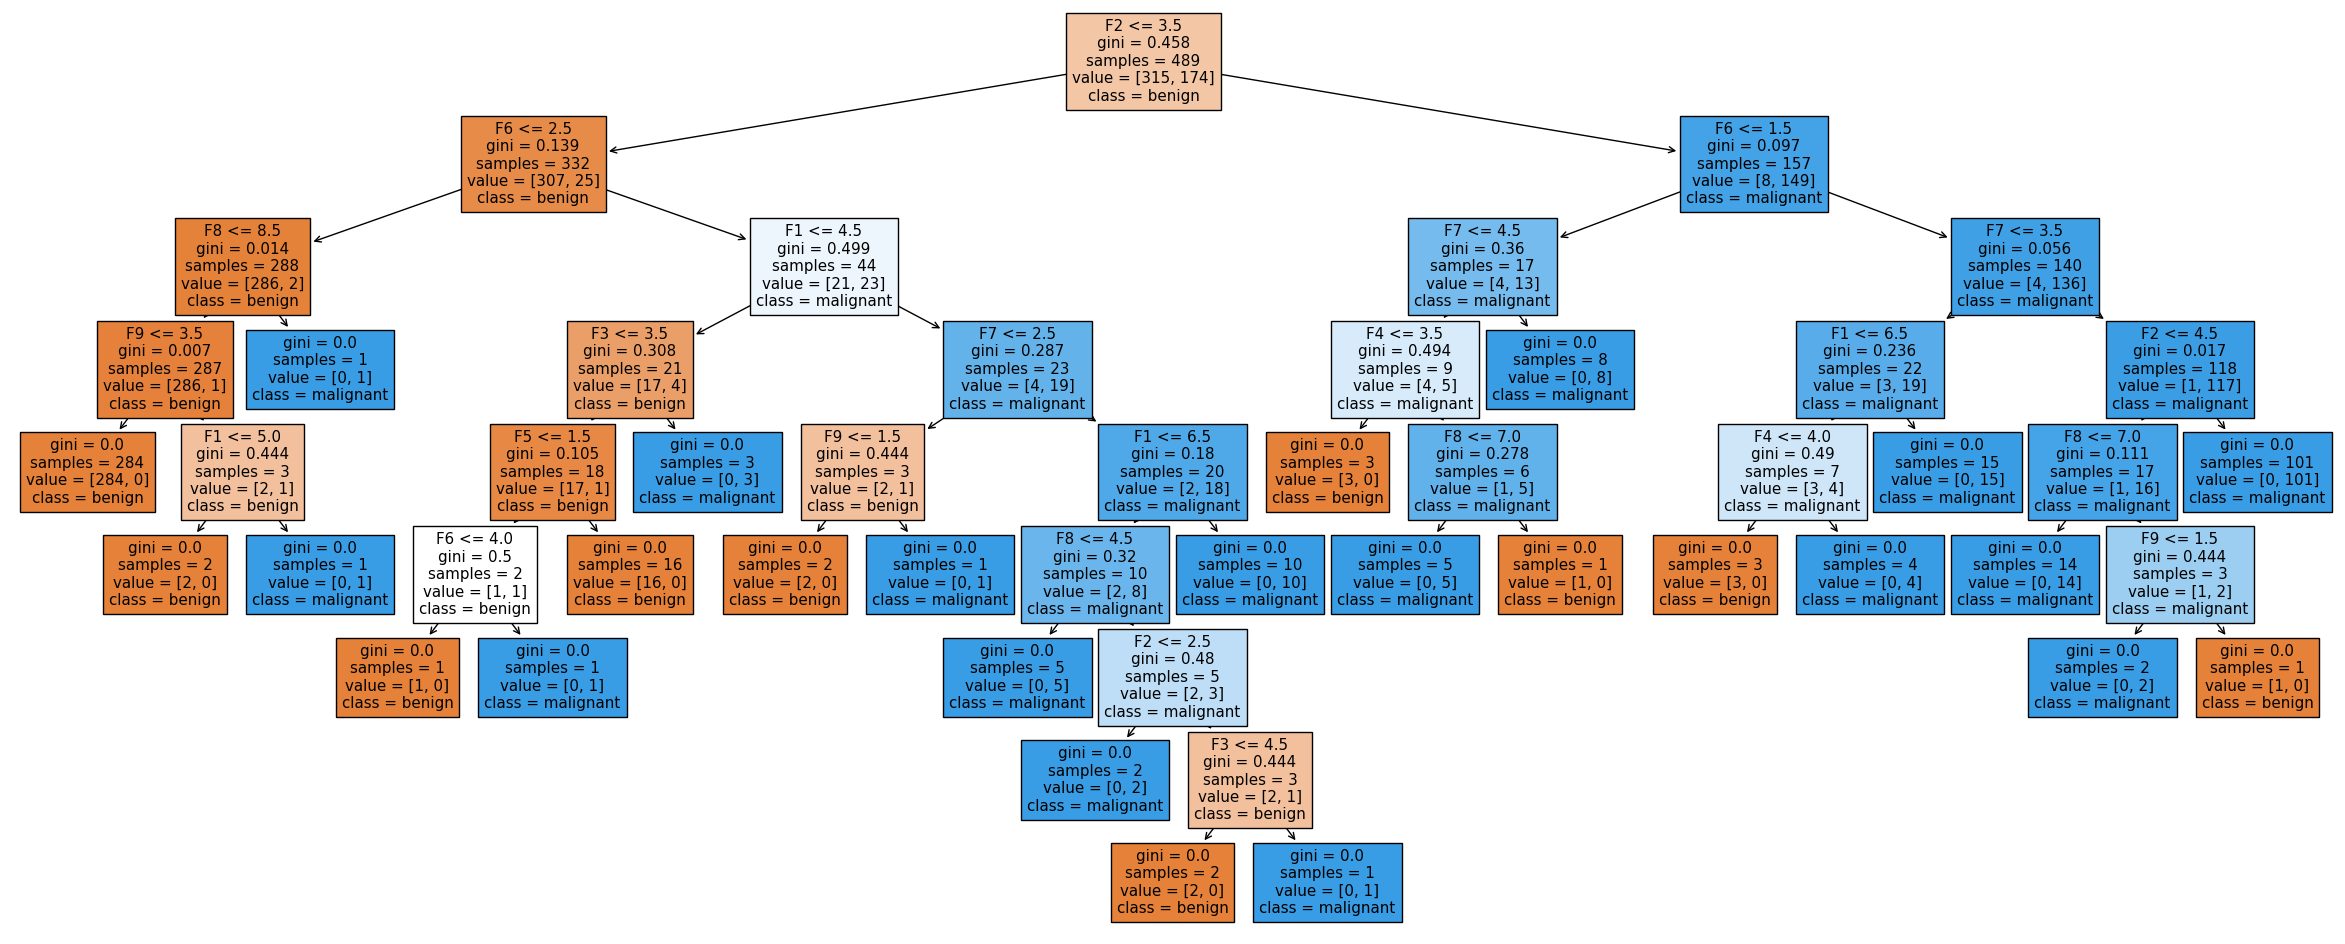

In [18]:
# See what an sklearn classifier comes up with first
clf = DecisionTreeClassifier()
 
# Fit classifier to dataset
clf.fit(train[features], train[target])

# Plot tree
fig, ax = plt.subplots(1, 1, figsize=(30, 12))
plot = plot_tree(clf, ax=ax, feature_names=features, class_names=['benign', 'malignant'], filled=True)

### Now try with my "from-scratch" code

In [19]:
single_cart = SingleCART(data=train, target='Class')

In [20]:
single_cart.calc_gini()

,F1,F2,F3,F4,F5,F6,F7,F8,F9
1,0.059350,0.029191,0.016528,0.160049,0.068878,0.091591,0.018866,0.191327,0.360325
2,0.113866,0.320000,0.258034,0.439156,0.129069,0.432133,0.085300,0.260355,0.218750
3,0.237187,0.498047,0.470416,0.498270,0.480000,0.495868,0.336036,0.341797,0.158790
4,0.244898,0.277778,0.429688,0.297521,0.290657,0.462810,0.297521,0.142012,0.000000
5,0.467280,0.000000,0.152778,0.244898,0.197531,0.423440,0.152778,0.231111,0.320000
6,0.499314,0.104938,0.083176,0.277778,0.000000,0.000000,0.000000,0.320000,0.000000
7,0.110727,0.142012,0.099723,0.000000,0.277778,0.277778,0.152778,0.297521,0.000000
8,0.218750,0.090703,0.083176,0.000000,0.124444,0.132653,0.000000,0.218750,0.244898
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.180000,NaN
10,0.000000,0.000000,0.000000,0.047591,0.000000,0.042990,0.000000,0.000000,0.000000


In [21]:
single_cart.get_best_gini_split()

(4, 'F9')

In [22]:
class CART:

    def __init__(self, data, target):

        self.data = data
        self.target = target
        self.features = data.columns.to_list(); self.features.remove(target)

        self.tree = {}
        self.build_tree()

    def split(self, data):

        single_cart = SingleCART(data=data, target=self.target)
        split_val, feature = single_cart.get_best_gini_split()

        split_func = lambda row: row[feature] <= split_val
        
        left = data[data.apply(split_func, axis=1)].drop(columns=feature)
        right = data.drop(index=left.index, columns=feature)

        split_dict = {
            'L': left,
            'R': right,
            'feature': feature,
            'split value': split_val,
            'L-Key': f"{feature} <= {split_val}",
            'R-Key': f"{feature} > {split_val}",
        }

        return split_dict
    
    def build_tree(self, data=None, tree=None):

        if data is None: 
            data = self.data
        
        if tree is None:
            tree = self.tree

        if data.empty: 
            return None

        if list(data.columns) == [self.target]:
            
            class_counts = data.value_counts()

            if class_counts.empty: 
                return None
            else: 
                return max(zip(class_counts.index, class_counts), key= lambda x: x[1])[0][0]
        
        else:

            split_dict = self.split(data)

            left = self.build_tree(data=split_dict['L'], tree={})
            right = self.build_tree(data=split_dict['R'], tree={})

            if left is not None:
                tree.update({split_dict['L-Key']: left})
            if right is not None:
                tree.update({split_dict['R-Key']: right})

            return tree
    
    def convert_key_to_func(self, key):

        if '>' in key:

            split_str = key.split('>')
            feature, split_val = split_str[0].strip(), float(split_str[1].strip())

            split_func = lambda x: x[feature] > split_val
        
        elif '<=' in key:

            split_str = key.split('<=')
            feature, split_val = split_str[0].strip(), float(split_str[1].strip())

            split_func = lambda x: x[feature] <= split_val  
        
        else:

            raise RuntimeError(f'Could not find inequality operator in key: "{key}"')
        
        return split_func

    def predict(self, x):

        node = self.tree
        max_depth = len(self.features);  iter_count = 0

        while isinstance(node, dict) and iter_count <= max_depth:
            for key in node.keys():

                split_func = self.convert_key_to_func(key)
                if split_func(x).all(): node = node[key]
            
            iter_count += 1
        
        return node



In [23]:
cart = CART(data=train, target='Class')

In [24]:
import json

with open('./HW-5-BreastCancerCART.json', 'w') as f:
    json.dump(cart.tree, fp=f, indent=4)

In [25]:
test['from scratch code prediction'] = test.drop(columns='Class').progress_apply(cart.predict, axis=1)
test['from scratch code correct'] = test['Class'] == test['from scratch code prediction']

  0%|          | 0/210 [00:00<?, ?it/s]

100%|██████████| 210/210 [00:00<00:00, 17551.49it/s]


In [26]:
test['sklearn prediction'] = clf.predict(test.drop(columns=['Class', 'from scratch code prediction', 'from scratch code correct']))
test['sklearn correct'] = test['Class'] == test['sklearn prediction']

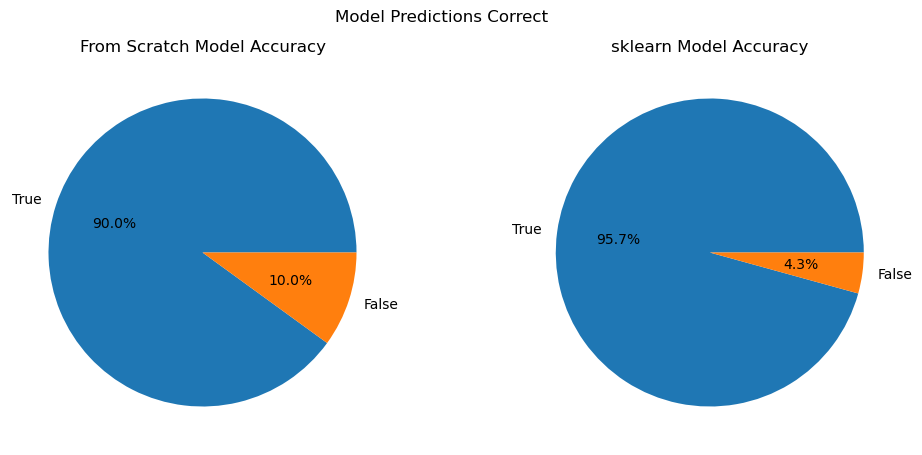

In [41]:
import matplotlib.pyplot as plt

fig, (scratch_ax, sklearn_ax) = plt.subplots(1, 2, figsize=(12, 5))

scratch_counts = test['from scratch code correct'].value_counts()
sklearn_counts = test['sklearn correct'].value_counts()

scratch_ax.pie(scratch_counts, autopct='%1.1f%%', labels=scratch_counts.index)
sklearn_ax.pie(sklearn_counts, autopct='%1.1f%%', labels=sklearn_counts.index)

scratch_ax.set_title('From Scratch Model Accuracy')
sklearn_ax.set_title('sklearn Model Accuracy')

fig.suptitle('Model Predictions Correct')

plt.show()